In [117]:
import pandas as pd
import numpy as np

In [118]:
names = ['user_id', 'item_id', 'rating', 'timestamp']
df = pd.read_table('/Users/wangjian/Desktop/ml-100k/u.data', sep='\t', names=names)
df.head()

,user_id,item_id,rating,timestamp
0,196,242,3,881250949
1,186,302,3,891717742
2,22,377,1,878887116
3,244,51,2,880606923
4,166,346,1,886397596


In [119]:
print('users:', df.user_id.nunique(),
     'items:', df.item_id.nunique())
#查看数据有多少个不同值。

('users:', 943, 'items:', 1682)


In [120]:
#构建user-by-item矩阵
ratings = np.zeros((df.user_id.nunique(), df.item_id.nunique()))
print ratings
for row in df.itertuples():#遍历df的行
    ratings[row[1]-1, row[2]-1] = row[3]
ratings

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


array([[5., 3., 4., ..., 0., 0., 0.],
       [4., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [5., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 5., 0., ..., 0., 0., 0.]])

In [121]:
sparsity = float(len(ratings.nonzero()[0]))
sparsity /= (ratings.shape[0] * ratings.shape[1])
sparsity *= 100
print('稀疏度：{:4.2f}%'.format(sparsity))

稀疏度：6.30%


In [122]:
##拆分数据集
np.random.seed(42)
def split(matrix):
    test=np.zeros(matrix.shape)
    train=matrix.copy()
    for user in range(matrix.shape[0]):
        #从训练集中删除每个用户10个评级并将其放入测试集。
        test_ratings=np.random.choice(matrix[user,:].nonzero()[0],size=10,replace=False)
        train[user,test_ratings]=0
        test[user,test_ratings]=matrix[user,test_ratings]
        #test and training are truly disjoint
        assert(np.all((train * test) == 0))
        return train, test

In [123]:
train,test=split(ratings)

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [124]:
print('train:', train.shape,
     'test:', test.shape)

('train:', (943, 1682), 'test:', (943, 1682))


In [125]:
def similarity(matrix,kind='user',epsilon=1e-9):#这里使用余弦相似度
    matrix = np.mat(matrix)
    #epsilon阻止上下溢出
    if kind=='user':
        sim=np.dot(matrix,matrix.T)+epsilon#用户之间直接使用相似度
    if kind=='item':
        sim=np.dot(matrix.T,matrix)+epsilon#物品之间直接使用评分
    norms=np.array([np.sqrt(np.diagonal(sim))])#
    return sim/norms/norms.T
#这里直接使用numpy里边的求内积函数.dot()加快计算，返回ratings的相似度矩阵

In [126]:
%%time
similarity(train,kind='item')

CPU times: user 178 ms, sys: 35.8 ms, total: 214 ms
Wall time: 115 ms


matrix([[1.00000000e+00, 4.02382178e-01, 3.30244787e-01, ...,
         5.89788339e-12, 4.71830671e-02, 4.71830671e-02],
        [4.02382178e-01, 1.00000000e+00, 2.73069175e-01, ...,
         1.30498938e-11, 7.82993627e-02, 7.82993627e-02],
        [3.30244787e-01, 2.73069175e-01, 1.00000000e+00, ...,
         1.61458421e-11, 1.07638947e-11, 9.68750526e-02],
        ...,
        [5.89788339e-12, 1.30498938e-11, 1.61458421e-11, ...,
         1.00000000e+00, 1.66666667e-10, 1.66666667e-10],
        [4.71830671e-02, 7.82993627e-02, 1.07638947e-11, ...,
         1.66666667e-10, 1.00000000e+00, 1.11111111e-10],
        [4.71830671e-02, 7.82993627e-02, 9.68750526e-02, ...,
         1.66666667e-10, 1.11111111e-10, 1.00000000e+00]])

In [127]:
user_similarity=similarity(train,kind='user')
item_similarity=similarity(train,kind='item')
item_similarity[:4,:4]


matrix([[1.        , 0.40238218, 0.33024479, 0.45493792],
        [0.40238218, 1.        , 0.27306918, 0.50257077],
        [0.33024479, 0.27306918, 1.        , 0.32486639],
        [0.45493792, 0.50257077, 0.32486639, 1.        ]])

In [149]:
def predict(matrix,similarity,kind='user'):
    matrix=np.mat(matrix)#要初始化
    similarity=np.mat(similarity)
    if kind == 'user':
        #similarity*ratings/
        return np.dot(similarity,matrix)/ np.abs(similarity).sum(axis=1)
    if kind == 'item':
        return np.dot(matrix,similarity) / np.abs(similarity).sum(axis=0)
    

In [150]:
def mse(pre,actual):
    #折叠成一维的数组
    pre=pre[actual.nonzero()].flatten()
    actual=actual[actual.nonzero()].flatten()
    return np.sum((pre - actual) * (pre- actual).T) / pre.size
    

In [151]:
item_prediction=predict(train,item_similarity,kind='item')
user_prediction=predict(train,user_similarity,kind='user')
print 'MSE_user:',mse(user_prediction,test)
print 'MSE_item',mse(item_prediction,test)

MSE_user: 7.886362842306729
MSE_item 6.95375528081747


In [15]:
#---------------------Top-k Recomendation-------------------------------------

In [259]:
def topk(matrix, similarity, kind='user', k=40):
    pred = np.zeros(matrix.shape)
    if kind == 'user':
        for i in range(matrix.shape[0]):
            top_k_users = np.argsort(similarity[:,i])[:-k-1:-1]
            #print(top_k_users)
            for j in range(matrix.shape[1]):
                #print(type(similarity[i, top_k_users]))
                #print(matrix[top_k_users, j])
                pred[i, j] = similarity[i, top_k_users].T * matrix[top_k_users, j]
                pred[i, j] /= np.sum(np.abs(similarity[i, top_k_users]))
    if kind == 'item':
        for j in range(matrix.shape[1]):
            top_k_items = np.argsort(similarity[:,j])[:-k-1:-1]
            for i in range(matrix.shape[0]):
                pred[i, j] = similarity[j, top_k_items].T * matrix[i, top_k_items]
                pred[i, j] /= np.sum(np.abs(similarity[j, top_k_items]))        
    
    return pred

pred = topk(train, item_similarity, kind='item', k=40)
print 'Top-k Item-based CF MSE: ', mse(pred, test)

pred = topk(train, user_similarity, kind='user', k=40)
print 'Top-k User-based CF MSE: ' , mse(pred, test)



KeyboardInterrupt: 

In [89]:
#------------------------选k,画图----------------------------------------

In [290]:
user_train_mse = []
user_test_mse = []
item_test_mse = []
item_train_mse = []
for i in range(5,100,10):
    user_pred=topk(train,user_similarity,kind='user',k=i)
    item_pred=topk(train,item_similarity,kind='item',k=i)
    
    user_train_mse.append(mse(user_pred,train))
    user_test_mse.append(mse(user_pred,test))
    
    item_test_mse.append(mse(item_pred,test))
    item_train_mse.append(mse(item_pred,train))


    



In [294]:
user_pred=topk(train,user_similarity,kind='user',k=5)

In [297]:
user_test_mse

[21.332047449521017,
 21.332047449521017,
 21.332047449521017,
 21.332047449521017,
 21.332047449521017,
 21.332047449521017,
 21.332047449521017,
 21.33204744952102,
 21.33204744952102,
 21.332047449521017]

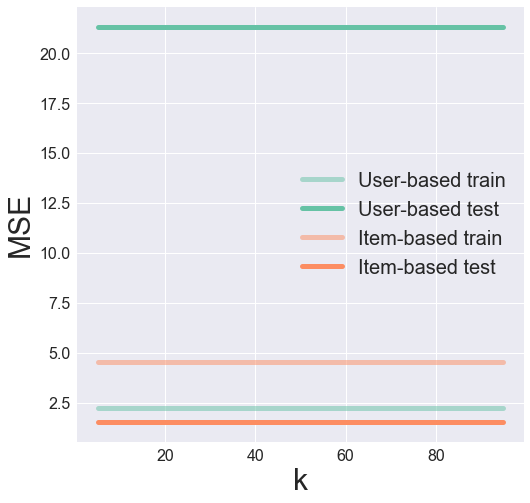

In [295]:
pal = sns.color_palette("Set2", 2)
s=[i for i in range(5,100,10)]
plt.figure(figsize=(8, 8))
plt.plot(s, user_train_mse, c=pal[0], label='User-based train', alpha=0.5, linewidth=5)
plt.plot(s, user_test_mse, c=pal[0], label='User-based test', linewidth=5)
plt.plot(s, item_train_mse, c=pal[1], label='Item-based train', alpha=0.5, linewidth=5)
plt.plot(s, item_test_mse, c=pal[1], label='Item-based test', linewidth=5)
plt.legend(loc='best', fontsize=20)
plt.xticks(fontsize=16);
plt.yticks(fontsize=16);
plt.xlabel('k', fontsize=30);
plt.ylabel('MSE', fontsize=30);

In [ ]:
#--------------------画图----------------------------------------

In [226]:
#-------------------predict_nobias预测模块-------------------------------------

In [232]:
matrix=train#(943,1682)
similarity=user_similarity#(943,943)
user_bias=matrix.mean(axis=1)
        #axis=0 对每一列求平均
        #axis=1 对每一行求平均
matrix=matrix-user_bias[:,np.newaxis].copy()
pred=np.dot(similarity,matrix)/np.abs(similarity).sum(axis=1)
pred+=user_bias[:,np.newaxis]

In [234]:
print('Bias-subtracted User-based CF MSE: ',mse(user_pred, test))

('Bias-subtracted User-based CF MSE: ', 13.3)


In [227]:
matrix=train#(943,1682)
similarity=item_similarity#(1682,1682)
item_bias=matrix.mean(axis=0)#(1682,)
matrix=matrix-item_bias[np.newaxis,:].copy() #copy(1,1682),m(943,1682)
pred=np.dot(matrix,similarity)/np.abs(similarity).sum(axis=0)#(943,1682)
pred+=item_bias[np.newaxis,:]#(943,1682)

In [231]:
print('Bias-subtracted Item-based CF MSE: ',mse(item_pred, test))

('Bias-subtracted Item-based CF MSE: ', 3.3)


In [236]:
#------------------------------------predict_nobias预测模块-----------------------------------

In [237]:
#---------------------------topk,predict_nobia合并模块---------------------------------

In [244]:
k=40
matrix=train
similarity=user_similarity
pred = np.zeros(matrix.shape)
user_bias=matrix.mean(axis=1)
matrxi=matrix-user_bias[:,np.newaxis].copy()
for i in range(matrix.shape[0]):
    top_k_users = np.argsort(similarity[:,i])[:-k-1:-1]
            #print(top_k_users)
    for j in range(matrix.shape[1]):
                #print(type(similarity[i, top_k_users]))
                #print(matrix[top_k_users, j])
        pred[i, j] = similarity[i, top_k_users].T * matrix[top_k_users, j]
        pred[i, j] /= np.sum(np.abs(similarity[i, top_k_users]))
pred+=user_bias[:, np.newaxis]
user_pred=pred
        
        



In [245]:
print('Bias-subtracted&topk User-based CF MSE: ',mse(user_pred, test))

('Bias-subtracted&topk User-based CF MSE: ', 21.332047449521017)


In [248]:
matrix=train #(943,1682)
similarity=item_similarity#(1682,1682)
pred = np.zeros(matrix.shape)#(943,1682)
item_bias=matrix.mean(axis=0)#(1682,)
matrxi=matrix-item_bias[np.newaxis,:].copy()#copy(1,1682),m(943,1682)
for j in range(matrix.shape[1]):
    top_k_items = np.argsort(similarity[:,j])[:-k-1:-1]
    for i in range(matrix.shape[0]):
        pred[i, j] = similarity[j, top_k_items].T * matrix[i, top_k_items]
        pred[i, j] /= np.sum(np.abs(similarity[j, top_k_items]))   
pred+=item_bias[np.newaxis,:]
item_pred=pred




In [249]:
print('Bias-subtracted&topk Item-based CF MSE: ',mse(item_pred, test))

('Bias-subtracted&topk Item-based CF MSE: ', 1.5392401534276194)
